# Step 0: Imports

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3

from math import sqrt
from collections import deque
import os
import random
from concurrent.futures import ProcessPoolExecutor
import pickle

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 15
MAX_TUNE_VTXS = 7
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
EPOCH_SIZE = 2**20
# vertices are labelled 1,2,...,MAX_VTXS
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [3]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            if u < v:
                edge_list += [u, v]
            else:
                edge_list += [v, u]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

def SSSP(G, target=2, distonly=True):
    dist = [MAX_VTXS] * len(G)
    parent = [-1] * len(G)
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    if distonly:
                        return dist[x]
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return MAX_VTXS if distonly else []

# large: size up to MAX_VTXS instead of MAX_TUNE_VTXS
# target: 2, "onpath", "any"
# largetarget: whether can go up to MAX_VTXS or just MAX_TUNE_VTXS
def mkbatch(size, large=True, target=2, largetarget=True):
    graphs = []
    dists = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS if large else MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            if target == 2:
                # Train data
                dist = SSSP(adj_list)
                # Filter out some short distance graphs
                if 6 <= dist < MAX_VTXS or (dist < 6 and 2 * random.random() < 1 / (6 - dist)) or (dist == MAX_VTXS and random.random() < 1 / MAX_VTXS):
                    edge_list[-1] = 2
                    break
            elif target == "onpath":
                path = SSSP(adj_list, 2, False)
                if len(path) < 1:
                    continue
                dist = random.randrange(1, len(path))
                if largetarget or path[dist] <= MAX_TUNE_VTXS:
                    edge_list[-1] = path[dist]
                    break
            elif target == "any":
                edge_list[-1] = random.randint(2, MAX_VTXS if largetarget else MAX_TUNE_VTXS)
                dist = SSSP(adj_list, edge_list[-1])
                break
        graphs.append(edge_list)
        dists.append(dist)
    
    data = torch.tensor(graphs)
    labels = torch.tensor(dists, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

def savebatch(size, idx):
    data, labels, padding = mkbatch(size)
    everything = {
        "data": data,
        "labels": labels,
        "padding": padding,
    }
    
    with open(f'data-new/{idx}.pickle', 'wb') as file:
        pickle.dump(everything, file)

In [4]:
# Only need to run this once to generate training data
# RESTART THE KERNEL BEFORE RUNNING AND ONLY RUN THE CELLS ABOVE
# Python is slow and awful

# with ProcessPoolExecutor() as executor:
#     for i in range(64):
#         executor.submit(savebatch, EPOCH_SIZE, i)
#     executor.shutdown()

In [4]:
mkbatch(3)

(tensor([[ 5, 11,  9, 10,  3,  4,  6, 13,  3,  9,  9, 13,  1, 10,  6,  8,  1,  2,
           6, 13,  4,  5,  1,  4,  2, 10,  0,  0,  0,  0,  2],
         [ 4, 10,  1, 10,  2,  7,  6,  9,  4,  5,  4,  6,  5,  7,  3,  5,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 9, 10,  3,  7,  1,  3,  5,  6, 13, 14,  1, 15,  4,  6,  4, 11,  2, 11,
           6, 13,  9, 15,  7, 14, 10, 12,  3, 15,  0,  0,  2]]),
 tensor([1., 5., 8.]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False,  True,  True,  True,  True,
          False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          False],
         [False, False, 

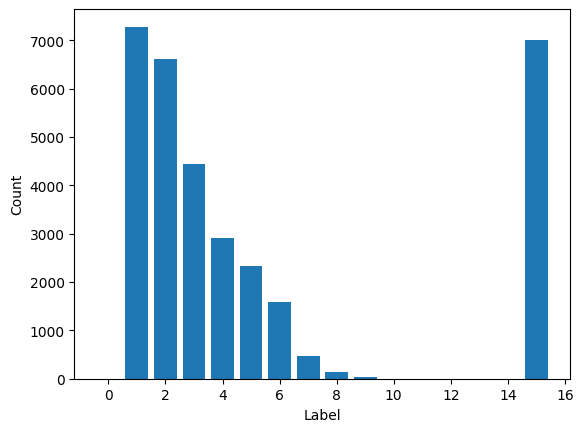

In [12]:
bins = torch.bincount(mkbatch(2**15)[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")
with open("plots/train-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

Text(0, 0.5, 'Count')

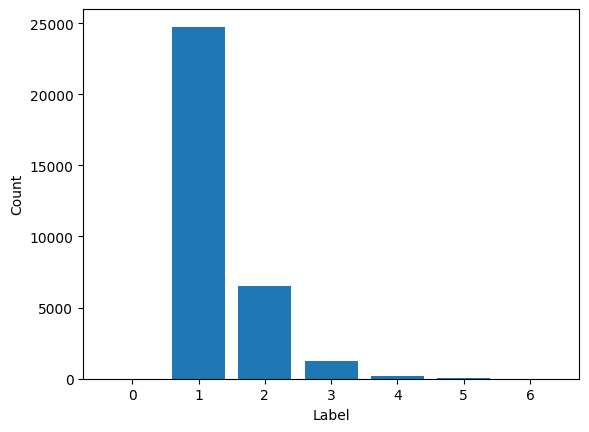

In [10]:
bins = torch.bincount(mkbatch(2**15, large=False, target="onpath")[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

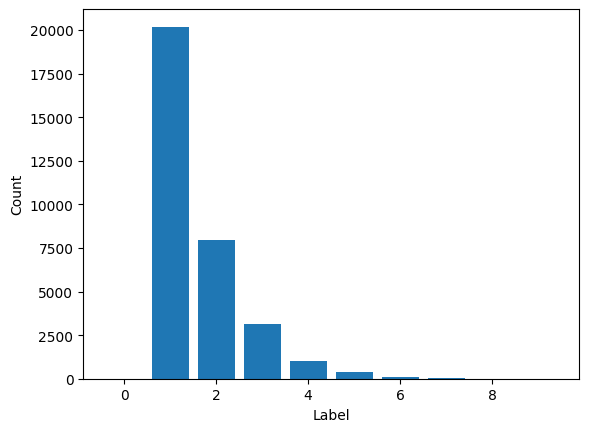

In [11]:
bins = torch.bincount(mkbatch(2**15, large=True, target="onpath", largetarget=False)[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")

# Step 2: Define Transformer Model

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [14]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 200
BSZ = 2**15 # Batch size
NHEADS = 2
NLAYERS = 11
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*EPOCH_SIZE//10**3}K")
print(f"Trainable parameters in the model: {trainable_params}")

train_err = []
len1 = []
len2 = []
len3 = []
leninf = []
epoch = 0

# clear loss file
open('loss', 'w').close()

Training data: 209715K
Trainable parameters in the model: 550433


In [15]:
# model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
#                          output_dim=1, num_heads=NHEADS,
#                          num_layers=NLAYERS, seq_len=SEQ_LEN,
#                          dropout=DROPOUT).to(device)
# model = torch.compile(model)
# model.load_state_dict(torch.load('model.pth', weights_only=True))

LR = 5e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Step 4: Train the Model for the first task

In [ ]:
while epoch < NEPOCHS:
    model.train()
    with open(f"data-new/{epoch}.pickle", "rb") as f:
        pickled_stuff = pickle.load(f)
    data = pickled_stuff["data"].to(device)
    label = pickled_stuff["labels"].to(device).to(torch.float32)
    padding = pickled_stuff["padding"].to(device)
    dataset = TensorDataset(data, label, padding)
    loader = DataLoader(dataset, batch_size=BSZ)
    for batch_src, batch_labels, batch_padding_mask in tqdm(loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        loss.backward()
        optimizer.step()
        
        train_err.append(loss.item())
        len1.append(criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels == 1]).item())
        len2.append(criterion(output[batch_labels == 2].squeeze(1), batch_labels[batch_labels == 2]).item())
        len3.append(criterion(output[batch_labels == 3].squeeze(1), batch_labels[batch_labels == 3]).item())
        leninf.append(criterion(output[batch_labels == MAX_VTXS].squeeze(1), batch_labels[batch_labels == MAX_VTXS]).item())
        
        with open('loss', 'a') as f:
            f.write(f"{train_err[-1]} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}\n")
    epoch_err = lambda l: sum(l[-EPOCH_SIZE // BSZ:]) / EPOCH_SIZE * BSZ
    print(f"Epoch {epoch}/{NEPOCHS} \t Train Err: {epoch_err(train_err)} {epoch_err(len1)} {epoch_err(len2)} {epoch_err(len3)} {epoch_err(leninf)}")

    epoch += 1
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_weights_{epoch}.pth")

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/functional.py:6278: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  attn_output = scaled_dot_product_attention(
/tmp/torchinductor_sipb/lc/clcqc3ufbzrethiy77dmsu54kurxdmh4eji2f3msm347rhmfpf4j.py:1078: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  extern_kernels.mm(reinterpret_tensor(buf1, (524288, 64), (64, 1), 0), reinterpret_tensor(primals_5, (64, 192), (1, 64), 0), out=buf2)

00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:41<00:00,  1.31s/it]

Epoch 0/200 	 Train Err: 29.90892779827118 11.204990872880444 6.002899471088313 2.7772275000461377 119.98257398605347



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 1/200 	 Train Err: 24.833097636699677 7.996231320299557 10.17519548535347 4.934848785400391 95.85787630081177



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 2/200 	 Train Err: 20.868117928504944 0.06162079039495438 9.863971814513206 5.750443048775196 84.68168807029724



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 3/200 	 Train Err: 16.48520603775978 0.03265308297704905 2.906232228502631 4.825529254972935 70.63315153121948



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 4/200 	 Train Err: 12.373839050531387 0.012339260501903482 1.0458019012585282 5.470552921295166 52.21906542778015



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 5/200 	 Train Err: 9.265015065670013 0.020387541531817988 0.6235579419881105 4.304356303066015 38.14229780435562



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 6/200 	 Train Err: 6.847102478146553 0.00765054406656418 0.34211935847997665 3.4029701724648476 27.37058013677597



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 7/200 	 Train Err: 5.120877355337143 0.006255884032725589 0.24545069271698594 2.8054168857634068 19.56860715150833



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 8/200 	 Train Err: 3.8786706030368805 0.01005001129124139 0.19835278647951782 2.2635713517665863 14.35572400689125



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 9/200 	 Train Err: 3.386067658662796 0.06476508973355521 0.3309611896984279 2.269792005419731 11.835063099861145



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.07it/s]

Epoch 10/200 	 Train Err: 2.6640610471367836 0.019311404510517605 0.15212045633234084 1.7280069142580032 9.439383015036583



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 11/200 	 Train Err: 2.271987594664097 0.004357099162007216 0.09561244037467986 1.4371714778244495 8.072030693292618



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 12/200 	 Train Err: 2.110176682472229 0.0037538947944995016 0.0762243423378095 1.3135331608355045 7.434565886855125



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 13/200 	 Train Err: 1.935215126723051 0.0025575611580279656 0.06788019218947738 1.1661983076483011 6.806286051869392



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 14/200 	 Train Err: 1.8060001619160175 0.0021859380358364433 0.05315158853773028 1.051108269020915 6.399133637547493



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.07it/s]

Epoch 15/200 	 Train Err: 1.7425284087657928 0.003451302447501803 0.042916826030705124 0.9607762675732374 6.2206505835056305



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 16/200 	 Train Err: 1.649382572621107 0.0032472783022967633 0.039788190391846 0.9184560999274254 5.846587151288986



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 17/200 	 Train Err: 1.6013295575976372 0.0026137664608540945 0.03258192975772545 0.8397737592458725 5.709988132119179



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 18/200 	 Train Err: 1.5462302453815937 0.002207836727393442 0.028909130429383367 0.7771711964160204 5.481079399585724



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 19/200 	 Train Err: 1.4744272604584694 0.002453724335282459 0.027229167113546282 0.7396254185587168 5.192027851939201



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 20/200 	 Train Err: 1.405750896781683 0.0035180113754904596 0.025897870946209878 0.7007174119353294 4.946545287966728



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 21/200 	 Train Err: 1.37083425745368 0.005473145276482683 0.026675976172555238 0.6762280324473977 4.781045973300934



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 22/200 	 Train Err: 1.3181258291006088 0.003216923019863316 0.02211966845788993 0.6302088163793087 4.611788898706436



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 23/200 	 Train Err: 1.270566176623106 0.0022422261081374018 0.019996988266939297 0.5934071252122521 4.4385934472084045



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 24/200 	 Train Err: 1.1932538747787476 0.004239499055984197 0.020018045412143692 0.552213310264051 4.133698016405106



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 25/200 	 Train Err: 1.173534195870161 0.00575368078352767 0.02177350874990225 0.5586085859686136 4.002377942204475



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 26/200 	 Train Err: 1.0854019112884998 0.003320175252156332 0.01748313583084382 0.5035764751955867 3.7186833322048187



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 27/200 	 Train Err: 1.0489223580807447 0.002155393432985875 0.014516596915200353 0.47800380270928144 3.589349642395973



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 28/200 	 Train Err: 1.0285752080380917 0.003717334211614798 0.01597064675297588 0.4826665371656418 3.4730969667434692



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 29/200 	 Train Err: 0.9720142241567373 0.004084829584826366 0.014119503815891221 0.43038015346974134 3.3248252645134926



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 30/200 	 Train Err: 0.9608706310391426 0.002451939526508795 0.011319156386889517 0.4139528265222907 3.2747417390346527



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 31/200 	 Train Err: 0.9179007802158594 0.002311610933247721 0.01079355452384334 0.3930521896108985 3.1119269728660583



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 32/200 	 Train Err: 0.8977434728294611 0.0021589329044218175 0.00950733212812338 0.3691776511259377 3.040615402162075



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 33/200 	 Train Err: 0.881706677377224 0.0020159517880529165 0.009437998596695252 0.35962088825181127 2.982758790254593



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 34/200 	 Train Err: 0.8403967656195164 0.001898838694614824 0.00869621682795696 0.3381345858797431 2.8688452169299126



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 35/200 	 Train Err: 0.8310248833149672 0.0013434199390758295 0.007526626766775735 0.32297050580382347 2.818771593272686



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 36/200 	 Train Err: 0.8045722767710686 0.0018811499339790316 0.0069304521166486666 0.30397533625364304 2.722321219742298



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 37/200 	 Train Err: 0.807910643517971 0.0022051451851439197 0.007862750302592758 0.30017248587682843 2.739243097603321



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.07it/s]

Epoch 38/200 	 Train Err: 0.7853260803967714 0.005179399433473009 0.008613282887381501 0.2864332143217325 2.6513936147093773



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 39/200 	 Train Err: 0.7792632356286049 0.004665168027713662 0.009170589764835313 0.277913779951632 2.6232368499040604



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 40/200 	 Train Err: 0.7583489026874304 0.00292711379006505 0.007873743350501172 0.27461743634194136 2.522021509706974



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 41/200 	 Train Err: 0.7282119914889336 0.0017558942890900653 0.006133111986855511 0.23886349285021424 2.4373623058199883



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 42/200 	 Train Err: 0.7180026862770319 0.0023761796346661868 0.006810532162489835 0.23614320810884237 2.375364724546671



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 43/200 	 Train Err: 0.7019325699657202 0.005046901515015634 0.008944688888732344 0.22622147155925632 2.30900501832366



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 44/200 	 Train Err: 0.6817822623997927 0.0017093055594159523 0.005646904020977672 0.21380048524588346 2.223499771207571



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 45/200 	 Train Err: 0.6641208492219448 0.0038460963405668736 0.0067629652403411455 0.21014394168742 2.1612670943140984



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 46/200 	 Train Err: 0.6523595433682203 0.0018703954374359455 0.006019242704496719 0.20436032535508275 2.1252111680805683



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 47/200 	 Train Err: 0.617787566035986 0.0030503157668135827 0.0069770159825566225 0.1832384041044861 1.9817177206277847



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 48/200 	 Train Err: 0.600332060828805 0.002064528713162872 0.0051435344576020725 0.17475251341238618 1.9067389331758022



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 49/200 	 Train Err: 0.5904311630874872 0.004617106849764241 0.006938040380191524 0.16196146188303828 1.8893518187105656



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 50/200 	 Train Err: 0.5741921290755272 0.004996264638975845 0.007533758063800633 0.15988326235674322 1.8061449080705643



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 51/200 	 Train Err: 0.532125998288393 0.001918236821438768 0.0039053107029758394 0.1349696076940745 1.6755047999322414



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 52/200 	 Train Err: 0.5333235822618008 0.002287628563863109 0.005320303003827576 0.14349294803105295 1.6620671227574348



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 53/200 	 Train Err: 0.4952954547479749 0.0010008449244196527 0.003929206512111705 0.1226266548037529 1.5398627035319805



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 54/200 	 Train Err: 0.490776726976037 0.0021560709155892255 0.004821252721740166 0.12306429445743561 1.5102213434875011



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 55/200 	 Train Err: 0.4630659334361553 0.002020925041506416 0.0043996189124300145 0.11745399446226656 1.4124069288372993



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 56/200 	 Train Err: 0.4430495109409094 0.0022180716405273415 0.004020084164949367 0.10757899098098278 1.3317870814353228



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 57/200 	 Train Err: 0.45779580902308226 0.007255890723172342 0.010569222271442413 0.1332057132385671 1.3446197882294655



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.07it/s]

Epoch 58/200 	 Train Err: 0.40347473975270987 0.0013051820133114234 0.0031506957930105273 0.09731322806328535 1.1896578464657068



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 59/200 	 Train Err: 0.3944752989336848 0.0025091177740250714 0.005466303970024455 0.10591710731387138 1.1414270270615816



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 60/200 	 Train Err: 0.3850894244387746 0.0022618337816311396 0.00499681286237319 0.10177210683468729 1.1139366328716278



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 61/200 	 Train Err: 0.3536613713949919 0.0016294859724439448 0.003189665607351344 0.09225898724980652 1.0001246724277735



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 62/200 	 Train Err: 0.3431710870936513 0.0014996515783423092 0.0034722756390692666 0.09043321071658283 0.9589487668126822



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 63/200 	 Train Err: 0.3311467822641134 0.001135409189373604 0.0031531365275441203 0.0849773638183251 0.9113363474607468



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 64/200 	 Train Err: 0.31347283348441124 0.0010190900329689612 0.003212062452803366 0.08056736667640507 0.8582371436059475



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 65/200 	 Train Err: 0.2970640519633889 0.0010584184110484784 0.002994029131514253 0.07881279999855906 0.8098555449396372



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 66/200 	 Train Err: 0.2887888355180621 0.0012073961215719464 0.0033224597755179275 0.0822362134931609 0.7632680460810661



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 67/200 	 Train Err: 0.27321118395775557 0.0009283916206186404 0.0024455750972265378 0.07351583207491785 0.7209800574928522



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 68/200 	 Train Err: 0.2642599456012249 0.0024096847391774645 0.004758599683555076 0.07438989775255322 0.6782895382493734



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 69/200 	 Train Err: 0.24411699920892715 0.0009143148763541831 0.002384097140748054 0.06588289514183998 0.637260627001524



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 70/200 	 Train Err: 0.2355448892340064 0.0011828851866084733 0.00317692070530029 0.07014255912508816 0.5985564198344946



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 71/200 	 Train Err: 0.22664254251867533 0.0011206458884771564 0.002485872115357779 0.06011384085286409 0.5786449136212468



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 72/200 	 Train Err: 0.21451926324516535 0.0008609092228653026 0.002164756482670782 0.0564098390750587 0.5476357256993651



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 73/200 	 Train Err: 0.2044255300424993 0.0010747715696197702 0.00229402982222382 0.05511317937634885 0.5015372652560472



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 74/200 	 Train Err: 0.200456322170794 0.001536047003355634 0.003252933354815468 0.05711311026243493 0.48181435000151396



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 75/200 	 Train Err: 0.19111737608909607 0.003518748955684714 0.004175829379164497 0.049318774370476604 0.45180629566311836



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 76/200 	 Train Err: 0.1808590106666088 0.0013624421417262056 0.002329483479115879 0.04611049557570368 0.4279420841485262



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 77/200 	 Train Err: 0.16973466146737337 0.0008994456393338623 0.00207517536728119 0.04326868336647749 0.3952533109113574



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 78/200 	 Train Err: 0.1702535841614008 0.0007078972075760248 0.0016872428823262453 0.04189401387702674 0.3984428942203522



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 79/200 	 Train Err: 0.16377683635801077 0.0013382542465478764 0.0027396336699894164 0.04209184244973585 0.3769973455928266



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 80/200 	 Train Err: 0.1497581924777478 0.0016949967903201468 0.0021530323319893796 0.03568895586067811 0.33177076652646065



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 81/200 	 Train Err: 0.14450395992025733 0.001401656336383894 0.002270640025017201 0.03478072857251391 0.317978051956743



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 82/200 	 Train Err: 0.1389398977626115 0.0033198261371580884 0.00435145793017 0.0375910610309802 0.28218549815937877



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 83/200 	 Train Err: 0.12944017979316413 0.0013174645964681986 0.0020839970657107187 0.033180530241224915 0.2718075602315366



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 84/200 	 Train Err: 0.1269651602488011 0.001952557386175613 0.002797932973408024 0.030586290056817234 0.2562156552448869



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 85/200 	 Train Err: 0.1262973020784557 0.0034579528983158525 0.004187718592220335 0.03295240050647408 0.26100850058719516



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 86/200 	 Train Err: 0.11676973546855152 0.002271431191729789 0.0028272587187530007 0.029616059619002044 0.22773186769336462



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 87/200 	 Train Err: 0.11645400826819241 0.003942164817090088 0.004389651330711786 0.02888663241174072 0.22617254313081503



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 88/200 	 Train Err: 0.1069438960403204 0.0007534859851148212 0.0015284864657587605 0.02535622369032353 0.20643022749572992



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 89/200 	 Train Err: 0.1019233949482441 0.0009516884665572434 0.001511421851319028 0.024724961316678673 0.18514555739238858



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 90/200 	 Train Err: 0.09508711867965758 0.0008840842388053716 0.0013085861846775515 0.022952270082896575 0.17402319004759192



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 91/200 	 Train Err: 0.09273395943455398 0.0008308457795465074 0.0014873276431899285 0.020763451553648338 0.1700441548600793



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 92/200 	 Train Err: 0.08730011875741184 0.000720000532510312 0.0011607171036303043 0.020305267593357712 0.15585350175388157



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 93/200 	 Train Err: 0.08319679484702647 0.0007787930949234578 0.0012370077938612667 0.018640907626831904 0.14242116385139525



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 94/200 	 Train Err: 0.08445112314075232 0.002024608746069134 0.0023303976749957656 0.0193185547250323 0.14395680534653366



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 95/200 	 Train Err: 0.0859984909184277 0.001967401332422014 0.002160638517125335 0.02076483884593472 0.14143188181333244



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 96/200 	 Train Err: 0.07500915951095521 0.0011493155893731455 0.0014125802363196271 0.019469743536319584 0.12187899858690798



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 97/200 	 Train Err: 0.07068800239358097 0.0006672579925179889 0.0009655766079958994 0.01619866766850464 0.11232927581295371



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 98/200 	 Train Err: 0.06899663107469678 0.0029092533500261197 0.002759141156275291 0.01706777891376987 0.10129301541019231



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 99/200 	 Train Err: 0.06587723165284842 0.0010087788145938248 0.0015239717367876437 0.015540250373305753 0.10049017099663615



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 100/200 	 Train Err: 0.06758000492118299 0.0019963337617809884 0.0021085088956169784 0.018880482559325173 0.10054084449075162



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 101/200 	 Train Err: 0.06307036883663386 0.0012753937157867767 0.0016400622589571867 0.015593403164530173 0.09352678328286856



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 102/200 	 Train Err: 0.060316542629152536 0.0006818027850385988 0.0010231798241875367 0.013433107393211685 0.09090642654336989



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 103/200 	 Train Err: 0.060421090107411146 0.0027040049144488876 0.0027294684268781566 0.01441186985175591 0.0847808476537466



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 104/200 	 Train Err: 0.05678413005080074 0.001134833364176302 0.001431436577149725 0.012649833428440616 0.0780830224393867



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 105/200 	 Train Err: 0.05805800168309361 0.003231210850572097 0.003441706239755149 0.015121193689992651 0.0752038118080236



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 106/200 	 Train Err: 0.0547659246949479 0.002454680496839501 0.002737534454809065 0.013384125923039392 0.07274198567029089



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 107/200 	 Train Err: 0.04927568801213056 0.0005825197017657047 0.0007837470261620183 0.010716092379880138 0.05965513514820486



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 108/200 	 Train Err: 0.05318018130492419 0.0013841798254361493 0.0015562751477773418 0.01211979822255671 0.07018060437985696



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 109/200 	 Train Err: 0.051697830320335925 0.0010280100987074547 0.001098815353543614 0.010801961965626106 0.06942529141088016



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 110/200 	 Train Err: 0.04692836094181985 0.0008446434776487877 0.0008702427021489711 0.01032250898424536 0.05933116714004427



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 111/200 	 Train Err: 0.044668186688795686 0.0011062668152135302 0.0010394338919468282 0.009862772989436053 0.054550442087929696



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 112/200 	 Train Err: 0.0447915755212307 0.0014217505979559064 0.0016150277879205532 0.010183335049077868 0.05510500964010134



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 113/200 	 Train Err: 0.043250435031950474 0.002363460382412086 0.002828258522640681 0.00971244159154594 0.047139356975094415



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 114/200 	 Train Err: 0.045086685102432966 0.0011699077874709474 0.0013979203313283506 0.010937912025838159 0.0543683817377314



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 115/200 	 Train Err: 0.0411334311356768 0.0013191173275117762 0.0011784266635004315 0.00858650918235071 0.04524634237168357



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 116/200 	 Train Err: 0.039555212075356394 0.0005507277148808498 0.0005802504801977193 0.007789377530571073 0.04690207863677642



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 117/200 	 Train Err: 0.03692283679265529 0.00043711723651540524 0.0005214224675000878 0.007687705321586691 0.03813074165373109



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 118/200 	 Train Err: 0.03628927277168259 0.00044126920215603604 0.0005619980265691993 0.007773650635499507 0.0384644401492551



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 119/200 	 Train Err: 0.03890394070185721 0.001729899499878229 0.001493205483257043 0.00798933092301013 0.041969388112192973



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 120/200 	 Train Err: 0.03712784848175943 0.0007071991701650404 0.0008030551111914974 0.007690385325986426 0.04134120314847678



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 121/200 	 Train Err: 0.03516055888030678 0.0004485433178160747 0.0006193339004312293 0.006722165890096221 0.03440287291596178



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 122/200 	 Train Err: 0.03431048977654427 0.0007996012898274785 0.000579838467274385 0.007459181011654437 0.03256209765095264



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 123/200 	 Train Err: 0.0351686873473227 0.0006591397341253469 0.0006555682361977233 0.006613661207666155 0.037333723666961305



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 124/200 	 Train Err: 0.03355215600458905 0.0002945618743979139 0.0004387611575111805 0.006839323941676412 0.034134260716200515



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 125/200 	 Train Err: 0.029283913841936737 0.00046266792719507066 0.00058449966218177 0.0056224113504868 0.024552044065785594



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 126/200 	 Train Err: 0.03119118546601385 0.0005014674925405416 0.0007099974022821698 0.0060376596375135705 0.02815229452244239



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 127/200 	 Train Err: 0.031841877149417996 0.00027776491560871364 0.00046666834350617137 0.005703783383069094 0.03038091241910479



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 128/200 	 Train Err: 0.030603406310547143 0.0006404905841463915 0.0006846741659956024 0.006221181378350593 0.025205713599461887



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 129/200 	 Train Err: 0.029333731392398477 0.0005602014119858723 0.000642365913336107 0.006284213814069517 0.02611703903221496



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 130/200 	 Train Err: 0.028047623636666685 0.0008307177447477443 0.0007543345300291548 0.006256156790186651 0.02223676520952722



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.07it/s]

Epoch 131/200 	 Train Err: 0.02852347370935604 0.0005703339811589103 0.0009201887021390576 0.005433428774267668 0.025521833274979144



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 132/200 	 Train Err: 0.028580970887560397 0.0005810092270621681 0.0005398729952048598 0.005319414980476722 0.027794180728960782



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 133/200 	 Train Err: 0.02704069105675444 0.0003059067348658573 0.0003909187862518593 0.0050654686710913666 0.023506886311224662



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 134/200 	 Train Err: 0.024850417801644653 0.00024160909720194468 0.0003672063955946214 0.004596906874212436 0.01910146742920915



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 135/200 	 Train Err: 0.024681290611624718 0.00037400397729925317 0.000489667942019878 0.004580263695970643 0.019593202690884937



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 136/200 	 Train Err: 0.027638425526674837 0.0004977623525519448 0.0005427452181265835 0.005582943878835067 0.02646890448522754



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 137/200 	 Train Err: 0.024757418257649988 0.0003685475935526483 0.0003517182428822707 0.004618304148607422 0.018053345412681665



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 138/200 	 Train Err: 0.02439499576576054 0.00027227840394061786 0.00036000374461764295 0.004171678388956934 0.020061984119138287



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 139/200 	 Train Err: 0.0229199705645442 0.00046586399253101263 0.0005068485352239804 0.004258882479916792 0.01709363247573492



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 140/200 	 Train Err: 0.024649846891406924 0.0006087151427891513 0.0007250320297771395 0.004237969173118472 0.022251372053233354



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 141/200 	 Train Err: 0.023699990182649344 0.0006855616327356984 0.0008273822963928978 0.004291944787837565 0.01694076002422662



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 142/200 	 Train Err: 0.022072256018873304 0.00023243963084951247 0.0003913031405318179 0.0035956969295511954 0.019112591930934286



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 143/200 	 Train Err: 0.023525280528701842 0.00040764258983472246 0.0003686606121391378 0.00405594674157328 0.02093119484015915



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 144/200 	 Train Err: 0.02343721961369738 0.00033207295859938313 0.0005353521628421731 0.004094722855370492 0.020869585259788437



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 145/200 	 Train Err: 0.02064004127169028 0.00022399188014787796 0.0003062049111122178 0.004059467602928635 0.017480447175330482



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 146/200 	 Train Err: 0.020763279171660542 0.0004162326339383071 0.0003410943327253335 0.0032998187525663525 0.01631780587376852



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 147/200 	 Train Err: 0.020571442728396505 0.00044352215627441183 0.0005010924719499599 0.003667172095447313 0.014751498597888713



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 148/200 	 Train Err: 0.01997521542944014 0.00021835572067629982 0.000277048953648773 0.0034534092810645234 0.015434162895644477



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 149/200 	 Train Err: 0.021312509546987712 0.00030864444181588624 0.0005689966556019499 0.004085102085809922 0.01556764474753436



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 150/200 	 Train Err: 0.019479235576000065 0.0003387887146573121 0.000369657065903084 0.003481321306026075 0.01391503391016613



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 151/200 	 Train Err: 0.023493657063227147 0.0003406951947226844 0.0004765782725826284 0.003387280346942134 0.024297427552482986



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 152/200 	 Train Err: 0.020062169001903385 0.0001796720187030587 0.0002183982696806197 0.003409319913771469 0.013818501599416777



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 153/200 	 Train Err: 0.019131189765175804 0.00029574484346994723 0.0002947069822312187 0.002951359812868759 0.01664116706706409



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 154/200 	 Train Err: 0.017693023837637156 0.00024806520877973526 0.0002983832400786923 0.00312236421086709 0.010928787386546901



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.07it/s]

Epoch 155/200 	 Train Err: 0.017173090571304783 0.00020240362800905132 0.0002837313263626129 0.0024838966492097825 0.01155280199873232



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 156/200 	 Train Err: 0.018064823234453797 0.00025287491257586225 0.00042023322453133005 0.0031510025983152445 0.013277582744422034



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 157/200 	 Train Err: 0.01679313532076776 0.00016895983264930692 0.00023369373479908973 0.0025660492974566296 0.013730080009736412



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 158/200 	 Train Err: 0.018779858626658097 0.0006825042137279524 0.00039098577053664485 0.0030517936720571015 0.014663536599073268



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 159/200 	 Train Err: 0.020110780431423336 0.000910040460212258 0.000834133242506141 0.004305297403334407 0.013905958928830842



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 160/200 	 Train Err: 0.019773374748183414 0.0009348806023581346 0.0008922487559175352 0.003975474533945089 0.01617197653695257



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 161/200 	 Train Err: 0.017475509172072634 0.00046213520988658274 0.0005404102516877174 0.003040906784008257 0.014273262689584953



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 162/200 	 Train Err: 0.015029630245408043 0.0001904235211895866 0.00021963075801068044 0.002168249424357782 0.010509091553103644



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 163/200 	 Train Err: 0.018164523935411125 0.0005775698982688482 0.0006741533361491747 0.0036203847994329408 0.011193782368536631



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 164/200 	 Train Err: 0.01632957032416016 0.0003306799113715897 0.0003712935063049372 0.0029763625025225338 0.009990961348194105



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 165/200 	 Train Err: 0.0153682763047982 0.0002632132137705412 0.0003610171986565547 0.0023970418515091296 0.012086256845577736



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 166/200 	 Train Err: 0.013866374094504863 0.00012185312010615235 0.00018107489950125455 0.0018877797901950544 0.008829483279441774



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 167/200 	 Train Err: 0.015403825411340222 0.00034605842233759176 0.00046738405558244267 0.002471095247528865 0.009661761823792858



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 168/200 	 Train Err: 0.015333578106947243 0.0007963078196553397 0.0006389631322463174 0.0029809060470142867 0.009118859635066201



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 169/200 	 Train Err: 0.01377101321122609 0.00028809423406528367 0.0002655940699014536 0.0022669341324217385 0.0077932964362616985



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 170/200 	 Train Err: 0.014377146551851183 0.0006095316629171066 0.000566291571203692 0.002504439868062036 0.007364666845887768



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 171/200 	 Train Err: 0.01476844641729258 0.0002849637266422178 0.00032093194135995873 0.002440014208332286 0.00954770603743782



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 172/200 	 Train Err: 0.014352218277053908 0.0001346213794590767 0.0002298443192785271 0.0027853190676978556 0.011637392487727993



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 173/200 	 Train Err: 0.013293113705003634 0.0002518077910735883 0.00021664196594883833 0.0016753806212363997 0.008185207087933577



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 174/200 	 Train Err: 0.01469786892994307 0.0005061904257672722 0.0006176612511126223 0.0025409646332263947 0.009795411139066346



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 175/200 	 Train Err: 0.01577709667617455 0.0002547664359440205 0.0003405914605991711 0.0020204293869028334 0.013386641423039691



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 176/200 	 Train Err: 0.014100697473622859 0.00036510653808363713 0.0004396585003405562 0.0022091059381637024 0.00978638644005514



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 177/200 	 Train Err: 0.014368639851454645 0.00044816699323746434 0.00045128344186196045 0.002814159254739934 0.008726180123630911



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 178/200 	 Train Err: 0.014014390297234058 0.0006206710049809772 0.00046763980253672344 0.002513490486308001 0.008434324339646082



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 179/200 	 Train Err: 0.011972312582656741 0.00018721630084428398 0.00029149899171443394 0.0016975146063487045 0.007282969920481719



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 180/200 	 Train Err: 0.01289494353113696 0.00020095304734013553 0.000251299350793488 0.0017014556851790985 0.010998782015121833



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 181/200 	 Train Err: 0.013175164320273325 0.000340911025944024 0.00035113496642225073 0.002221787386588403 0.008535892283987323



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 182/200 	 Train Err: 0.012816024391213432 0.0003103266114408143 0.00028728846336889546 0.0020579011925292434 0.00718217800522325



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 183/200 	 Train Err: 0.01449834939558059 0.0005017787769361348 0.0005829150882163958 0.002624640494104824 0.012894641169850729



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 184/200 	 Train Err: 0.01308623020304367 0.0003065749452275668 0.0002674301056231343 0.0018643831190274796 0.009087016163903172



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 185/200 	 Train Err: 0.011409497121348977 0.00029326116043648653 0.0003596148741280558 0.001658103732552263 0.007742758548488382



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 186/200 	 Train Err: 0.010975291283102706 0.00022339119993830536 0.00027696753636519134 0.0014451522856688825 0.0054481543454585335



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 187/200 	 Train Err: 0.010257220594212413 0.00023113110682970728 0.0002813607433154175 0.001320708272032789 0.005819132793249082



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 188/200 	 Train Err: 0.012054045568220317 0.000388129293298789 0.0004733345151635149 0.001878096192740486 0.00747043985700202



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 189/200 	 Train Err: 0.012783893820596859 0.00031030693571665324 0.00032841233428371197 0.0017014134382407065 0.006328187721919676



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 190/200 	 Train Err: 0.01047908267355524 0.000252351564199671 0.0003104653961827353 0.0015047969627630664 0.00647446524692441



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 191/200 	 Train Err: 0.01059192547108978 0.00032810493928536744 0.00036611615337278636 0.0015751951596030267 0.005902428454646724



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 192/200 	 Train Err: 0.011238765117013827 0.0005425223790780365 0.0005242744022098123 0.0020095554464205634 0.006199448111232186


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 24/32 [00:22<00:07,  1.03it/s]

In [12]:
def evaluate(data):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), data)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return output.detach(), batch_labels.detach().to(torch.uint8), loss.item()

def mkhist(data):
    y, x, loss = evaluate(data)
    print(loss)
    cnts = torch.bincount(x)
    weights = [1/cnts[i.item()].item() for i in x] # normalize by label count
    fig, ax = plt.subplots()
    h = ax.hist2d(x.cpu().numpy().flatten(), y.cpu().numpy().flatten(), weights=weights, bins=[15,50], norm=mpl.colors.LogNorm())
    ax.set_xlabel("Label")
    ax.set_ylabel("Model Output")
    fig.colorbar(h[3], ax=ax)

In [13]:
evaluate(mkbatch(BSZ))[2]

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  return torch._transformer_encoder_layer_fwd(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return torch._transformer_encoder_layer_fwd(


0.031184175983071327

In [ ]:
with open('loss') as f:
    losses = torch.tensor([list(map(float, l.split())) for l in f.readlines()])
plt.plot(torch.log(losses[:, 0]), label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
with open("plots/train-loss.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

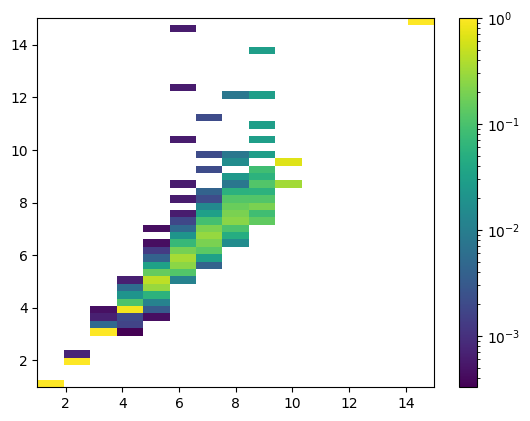

In [27]:
mkhist(mkbatch(BSZ))
plt.show()
with open("plots/train-hist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

In [ ]:
plt.suptitle('Log MSE vs Epochs')
plt.plot(torch.log(torch.tensor(losses[:, 0])), label='Train', color='blue')
plt.plot(torch.log(torch.tensor(losses[:, 1])), label='Len 1', color='red')
plt.plot(torch.log(torch.tensor(losses[:, 2])), label='Len 2', color='green')
plt.plot(torch.log(torch.tensor(losses[:, 3])), label='Len 3', color='yellow')
plt.plot(torch.log(torch.tensor(losses[:, 4])), label='Len 15', color='magenta')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.legend()
with open("plots/train-lens.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

# Step 5: Fine Tune

In [11]:
N_TUNE_EPOCHS = 100
TUNE_LR = 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR)

tune_train_err = []

# clear loss file
open('tune_loss', 'w').close()

In [15]:
for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ, large=False, target="onpath"))
    optimizer.zero_grad()
    output = model(batch_src, batch_padding_mask)
    loss = criterion(output.squeeze(1), batch_labels)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss}\n")
    print(f"Epoch {epoch}/{N_TUNE_EPOCHS} \t Train Err: {train_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"checkpoints/tune_model_weights_{epoch + 1}.pth")

Epoch 0/100 	 Train Err: 0.4553
Epoch 1/100 	 Train Err: 0.2545
Epoch 2/100 	 Train Err: 0.2368
Epoch 3/100 	 Train Err: 0.2138
Epoch 4/100 	 Train Err: 0.1898
Epoch 5/100 	 Train Err: 0.1931
Epoch 6/100 	 Train Err: 0.1948
Epoch 7/100 	 Train Err: 0.1847
Epoch 8/100 	 Train Err: 0.1638
Epoch 9/100 	 Train Err: 0.1490
Epoch 10/100 	 Train Err: 0.1457
Epoch 11/100 	 Train Err: 0.1509
Epoch 12/100 	 Train Err: 0.1537
Epoch 13/100 	 Train Err: 0.1472
Epoch 14/100 	 Train Err: 0.1369
Epoch 15/100 	 Train Err: 0.1304
Epoch 16/100 	 Train Err: 0.1257
Epoch 17/100 	 Train Err: 0.1201
Epoch 18/100 	 Train Err: 0.1160
Epoch 19/100 	 Train Err: 0.1064
Epoch 20/100 	 Train Err: 0.1026
Epoch 21/100 	 Train Err: 0.0964
Epoch 22/100 	 Train Err: 0.1165
Epoch 23/100 	 Train Err: 0.0990
Epoch 24/100 	 Train Err: 0.0691
Epoch 25/100 	 Train Err: 0.0633
Epoch 26/100 	 Train Err: 0.0552
Epoch 27/100 	 Train Err: 0.0505
Epoch 28/100 	 Train Err: 0.0429
Epoch 29/100 	 Train Err: 0.0376
Epoch 30/100 	 Train

In [19]:
evaluate(mkbatch(BSZ, large=False, target="onpath"))[2]

0.001733972690999508

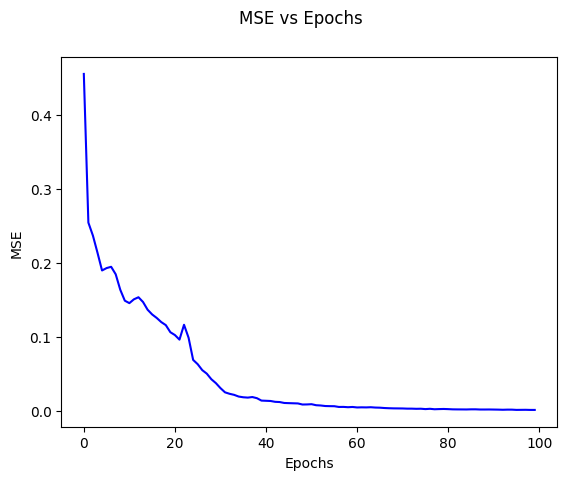

In [17]:
plt.suptitle('Log MSE vs Epochs')
plt.plot(torch.log(tune_train_err), label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.show()
with open("plots/tune-loss.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

(array([[6.0290e+03, 1.8597e+04, 8.4000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00]]),
 array([1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  , 1.699, 1.8  ,
        1.9  , 2.   , 2.1  , 2.2  , 2.3  , 2.398, 2.5  , 2.6  , 2.7  ,
        2.8  , 2.898, 3.   , 3.1  , 3.2  , 3.299, 3.398, 3.5  , 3.6  ,
        3.7  , 3.799, 3.898, 4.   , 4.1  , 4.2  , 4.297, 4.4  , 4.5  ,
        4.6  , 4.7  , 4.797, 4.9  , 5.   , 5.098, 5.2  , 5.3  , 5.4  ,
        5.5  , 5.598, 5.7  , 5.797, 5.9  , 6.   ], dty

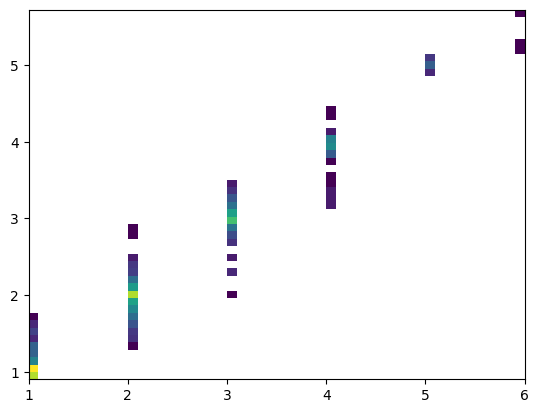

In [21]:
mkhist(mkbatch(BSZ, large=False, target="onpath"))
with open("plots/tune-hist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

# Step 6: Test generalization

In [ ]:
mkhist(mkbatch(BSZ, large=True, target="onpath", largetarget=False))
with open("plots/test-onpath-smalltarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

0.20130713284015656


(array([[1.7789e+04, 6.5000e+02, 4.8000e+02, ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([ 1.   ,  1.18 ,  1.36 ,  1.54 ,  1.721,  1.9  ,  2.08 ,  2.262,
         2.441,  2.621,  2.8  ,  2.98 ,  3.16 ,  3.34 ,  3.521,  3.701,
         3.88 ,  4.062,  4.242,  4.42 ,  4.6  ,  4.78 ,  4.96 ,  5.14 ,
         5.32 ,  5.5  ,  5.68 ,  5.863,  6.043,  6.223,  6.402,  6.582,
         6.76 ,  6.94 ,  7.12 ,  7.3  ,  7.48 ,  7.66 ,  7.844,  8.02 ,
         8.2  ,  8.38 ,  8.56 ,  8.74 ,  8.92 ,  

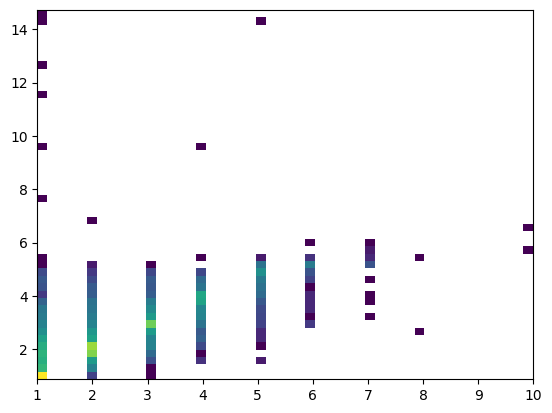

In [27]:
mkhist(mkbatch(BSZ, large=True, target="onpath", largetarget=True))
with open("plots/test-onpath-largetarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

In [ ]:
mkhist(mkbatch(BSZ, large=False, target="any", largetarget=False))
with open("plots/test-small-any.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

In [ ]:
mkhist(mkbatch(BSZ, large=True, target="any", largetarget=False))
with open("plots/test-large-any-smalltarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

In [ ]:
mkhist(mkbatch(BSZ, large=True, target="any", largetarget=True))
with open("plots/test-large-any-largetarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)